# Autoregression

The Autoregressive model is a time series modeling technique used to represent a type of random process. It is used when there's a direct relationship between an observation and the observations at previous steps. The model specifies that the output variable depends linearly on its own previous values and on a stochastic term.

The math behind the Autoregressive (AR) model of order p (AR(p)) can be written as:

    Yt = c + φ1Yt-1 + φ2Yt-2 + ... + φpYt-p + εt

Where,
  Yt: Output at time t
  c: Constant
  φi: Coefficient for the lagged output at i steps previous to time t
  εt: Error at time t

Assumptions:
1. The model assumes stationarity, that is, the properties of the series do not depend on the time at which the series is observed.
2. The errors are normally distributed with constant variance (homoscedasticity).
3. Errors are uncorrelated.


## Data Generation and Checking Assumptions

Let's generate some data and check whether it meets the assumptions of an autoregressive model.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

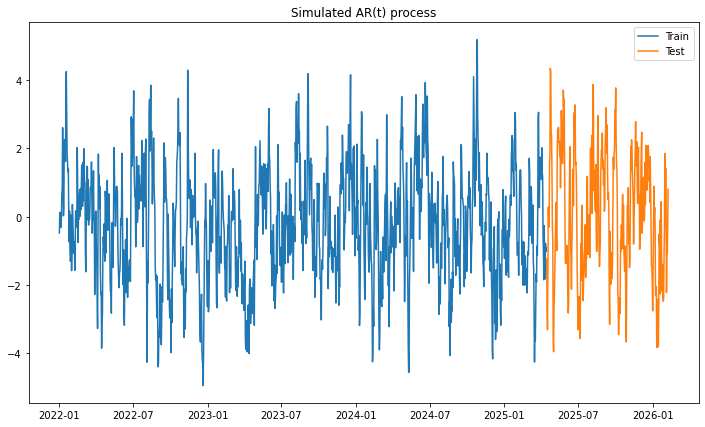

In [31]:
from statsmodels.tsa.arima_process import ArmaProcess

n = 1500
split_point = int(n*0.8)
dates = pd.date_range(start='2022-01-01', periods=n, freq='D')


# Simulate AR(1) with θ1 = 0.9
# AR(1) process: X_t =  c + 0.9*X_{t-1} + ε_t
# the AR parameter sign is reversed when used in ArmaProcess
# the zeroth lag of an AR process is 1
ar = np.array([1, -0.8])
ma = np.array([1])

AR_object = ArmaProcess(ar, ma) 
simulated_data = AR_object.generate_sample(nsample=n)

simulated_data = pd.Series(simulated_data, name='Values')
simulated_data.index = dates

simulated_data, test_simulated_data = simulated_data.iloc[:split_point], simulated_data.iloc[split_point:]

plt.figure(figsize=(12, 7))
plt.plot(simulated_data, label='Train')
plt.plot(test_simulated_data, label='Test')
plt.legend()
plt.title('Simulated AR(t) process')
plt.show()

In [32]:
from statsmodels.tsa.stattools import adfuller

# Check for stationarity
result = adfuller(simulated_data)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -8.215657
p-value: 0.000000


In the above code, we first generate some autoregressive data, and then we check for stationarity using the Augmented Dickey-Fuller test (ADF test). If the p-value of the ADF test is less than our chosen significance level (say 0.05), we can reject the null hypothesis of non-stationarity.

### Model Selection for Autoregression

Model selection involves determining the order of the autoregressive model, i.e., how many lagged past values we should use in our prediction. We use the Akaike Information Criterion (AIC) to determine the best model.

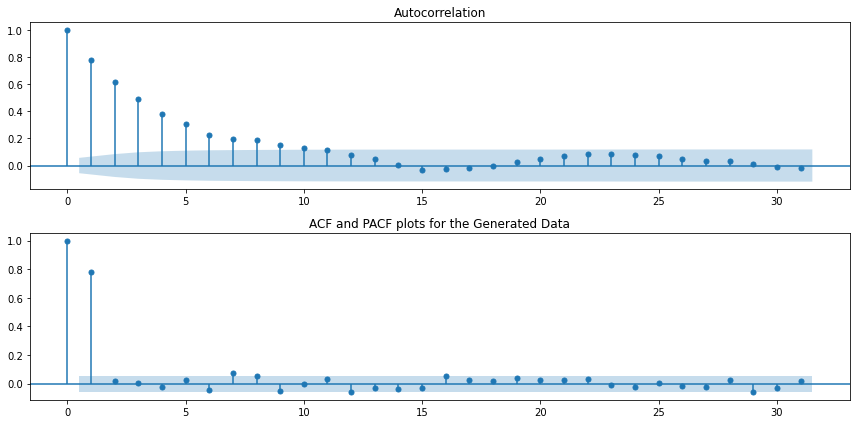

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2,figsize=(12,6))
plot_acf(simulated_data, ax=ax[0])  # Identifies the order of AR model
plot_pacf(simulated_data, ax=ax[1])  # Identifies the order of MA model
plt.title('ACF and PACF plots for the Generated Data')
plt.tight_layout()
plt.show()

From the acf/pacf plots, we can see that the time series is most likely an AR(1) given the large spike at lag 1 and the small spikes at the other lags. We can also look at the AIC values for different models and choose the one with the lowest AIC value.

Best model: AR(1), AIC = 0.05011929204708829


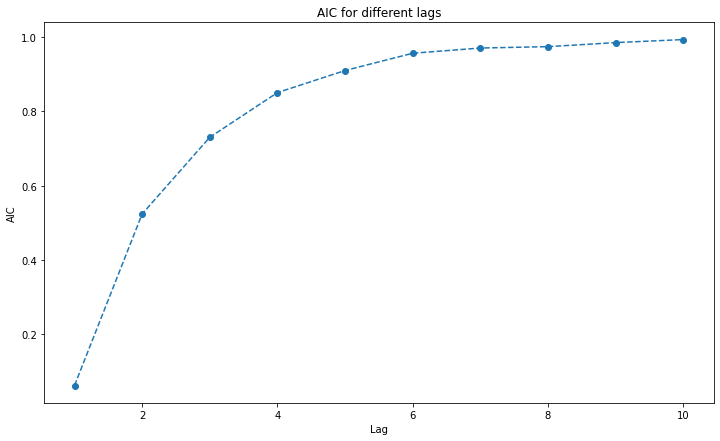

In [94]:
from statsmodels.tsa.ar_model import AutoReg
from itertools import product

# Define a range of lag values
max_lag = 10
lags = range(1, max_lag + 1)

# Find the best model (the one with the lowest AIC)
best_aic, best_order = np.inf, None

aic = []


for lag in lags:
    model = AutoReg(simulated_data, lags=[lag])
    result = model.fit()

    aic.append(result.bic)

    if result.aic < best_aic:
        best_aic = result.aic
        best_order = lag




print(f'Best model: AR({best_order}), AIC = {best_aic}')

plt.figure(figsize=(12, 7))
plt.plot(lags, aic, marker='o', linestyle='--')
plt.xlabel('Lag')
plt.ylabel('AIC')
plt.title('AIC for different lags')
plt.show()

In [95]:
# Fit the best model
model = AutoReg(endog = simulated_data, lags=best_order, trend='ct')
result = model.fit()

# Print the summary
print(result.summary())

                            AutoReg Model Results                             
Dep. Variable:                 Values   No. Observations:                 1200
Model:                     AutoReg(1)   Log Likelihood               -1728.349
Method:               Conditional MLE   S.D. of innovations              1.023
Date:                Mon, 18 Mar 2024   AIC                              0.052
Time:                        19:17:09   BIC                              0.069
Sample:                    01-02-2022   HQIC                             0.058
                         - 04-14-2025                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0582      0.059     -0.981      0.327      -0.175       0.058
trend       7.972e-06   8.53e-05      0.093      0.926      -0.000       0.000
Values.L1      0.7811      0.018     43.309      0.0

Values.L1 is not far from the coefficient for the lag of 0.8

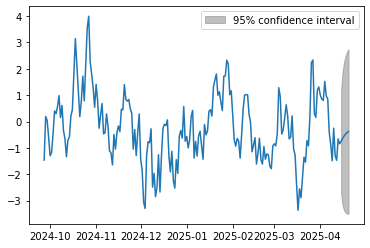

In [96]:
result.plot_predict(start=split_point-200, end=split_point+5)
plt.show()

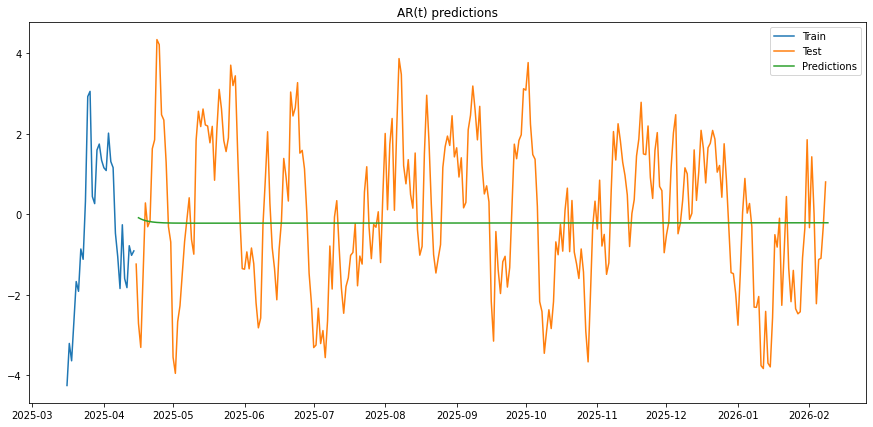

In [100]:
predictions = result.predict(start=split_point + 1, end=n, dynamic=True)

plt.figure(figsize=(15, 7))
plt.plot(simulated_data[-30:], label='Train')
plt.plot(test_simulated_data, label='Test')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.title('AR(t) predictions')
plt.show()

The model produces a relatively straight line.

### Compare to naive forecast

In [118]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_simulated_data, predictions)

# Naive forecast
# The naive forecast is the mean of the training set(the seen values)
naive_mse = mean_squared_error(test_simulated_data, [np.mean(simulated_data)]*len(test_simulated_data))

print(f'MSE: {mse}')
print(f'Naive MSE: {naive_mse}')

MSE: 3.33182943276654
Naive MSE: 3.3418576989631346
